In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import (KFold, StratifiedKFold, GroupKFold)
print(os.getcwd())

C:\Users\bogda\OneDrive\Desktop\Python\JPM DS


# Model Selection

Need a process to evaluate models in a non-biased fashion.
Bias:
- Training/test split
- Hyperparameter tuning
- Model design

## Car Purchase Dataset

In [2]:
df = pd.read_csv("ExData\car_data.csv")
df.set_index(["User ID"], inplace=True)
df = pd.concat([df, pd.get_dummies(df['Gender'])], axis=1)

In [3]:
df.describe()

Age   AnnualSalary    Purchased       Female         Male
count  1000.000000    1000.000000  1000.000000  1000.000000  1000.000000
mean     40.106000   72689.000000     0.402000     0.516000     0.484000
std      10.707073   34488.341867     0.490547     0.499994     0.499994
min      18.000000   15000.000000     0.000000     0.000000     0.000000
25%      32.000000   46375.000000     0.000000     0.000000     0.000000
50%      40.000000   72000.000000     0.000000     1.000000     0.000000
75%      48.000000   90000.000000     1.000000     1.000000     1.000000
max      63.000000  152500.000000     1.000000     1.000000     1.000000

## Cross-validation

Taking only one split of the data could have been a lucky draw or could have been biased if the data is not balanced. Cross-validation helps test for this by creating several training test splits and accessing the model on different samples of unseen data.

In [4]:
clf = tree.DecisionTreeClassifier(random_state=42)
scores = cross_val_score(clf, df[['Age', 'AnnualSalary', 'Female']], df['Purchased'], cv=5)
scores

array([0.88 , 0.875, 0.905, 0.875, 0.87 ])

How to generate hold out data? Use the test train split before hand to segment a portion of the dataset. The idea is now we would use cross validation to find the best performing model and then do one final validation on the holdout data.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df[['Age', 'AnnualSalary', 'Female']], df['Purchased'], test_size=0.2, random_state=0)

In [6]:
clf = tree.DecisionTreeClassifier(random_state=42)
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores

array([0.80625, 0.91875, 0.88125, 0.85625, 0.85   ])

In [7]:
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       121
           1       0.89      0.86      0.88        79

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.91      0.90       200



## Different Folds

You can test different folding techniques to minimize the model over fitting. 

- StratifiedKFold ensures proper representation of classes between folds. The class is the target. 
- GroupKFold ensure that groups are not split between folds. We don't have groups in our dataset, we could create groups by defining age ranges.
- StratifiedGroupKFold combines the two.

In [8]:
clf = tree.DecisionTreeClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5)
scores = cross_val_score(clf, X_train, y_train, cv=cv)
scores

array([0.80625, 0.91875, 0.88125, 0.85625, 0.85   ])

In [9]:
#broke up age column in group of 8-years range
df['AgeGroup'] = 0
df.loc[(df['Age'] >= 18) & (df['Age'] <=26), 'AgeGroup'] = 1
df.loc[(df['Age'] >= 27) & (df['Age'] <=35), 'AgeGroup'] = 2
df.loc[(df['Age'] >= 36) & (df['Age'] <=44), 'AgeGroup'] = 3
df.loc[(df['Age'] >= 45) & (df['Age'] <=53), 'AgeGroup'] = 4
df.loc[(df['Age'] >= 54) & (df['Age'] <=62), 'AgeGroup'] = 5
df.loc[(df['Age'] >= 63), 'AgeGroup'] = 6

df.head(10)

Gender  Age  AnnualSalary  Purchased  Female  Male  AgeGroup
User ID                                                              
385        Male   35         20000          0       0     1         2
681        Male   40         43500          0       0     1         3
353        Male   49         74000          0       0     1         4
895        Male   40        107500          1       0     1         3
661        Male   25         79000          0       0     1         1
846      Female   47         33500          1       1     0         4
219      Female   46        132500          1       1     0         4
588        Male   42         64000          0       0     1         3
85       Female   30         84500          0       1     0         2
465        Male   41         52000          0       0     1         3

In [10]:
df['AgeGroup'].value_counts()

3    340
4    213
2    210
5    116
1    114
6      7
Name: AgeGroup, dtype: int64

In [11]:
df.groupby(['AgeGroup'])['Purchased'].value_counts()

AgeGroup  Purchased
1         0            114
2         0            179
          1             31
3         0            248
          1             92
4         1            163
          0             50
5         1            109
          0              7
6         1              7
Name: Purchased, dtype: int64

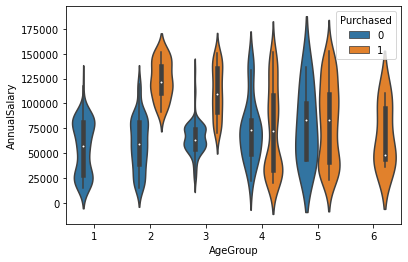

In [12]:
sns.violinplot(data=df, x='AgeGroup', y='AnnualSalary', hue='Purchased' )
plt.show()

In [13]:
cv = GroupKFold(n_splits=6)  # Must me less than or equal to number of groups
cv.split(df[['AnnualSalary', 'Female']], df['Purchased'], groups=df['AgeGroup'])

<generator object _BaseKFold.split at 0x00000204EC8F0C80>

Notice how we now have a generator object, which produces an numerical index of which observations belong in each fold iteration. These can be use in a for loop and the observations can be accessed using .iloc[]. 

In [16]:
predictCols = [1, 2, 4]  #cols 1, 2, 4 = Age, AnnualSalary, Female
# predictCols = [2, 4] #try running with Age removed
targetCol = [3] #col 3 = Purchased
scores = [] #to keep the scores of all trained models

for train_index, test_index in cv.split(df[['AnnualSalary', 'Female']], df['Purchased'], groups=df['AgeGroup']):
    print("Hold-out group:",df.iloc[test_index, -1].unique()) #print out which test group was hold out
    
    clf.fit(df.iloc[train_index, predictCols], df.iloc[train_index, targetCol])
    score = clf.score(df.iloc[test_index, predictCols], df.iloc[test_index, targetCol])
    scores.append(score)
    print("Score:",score)
    print(classification_report(df.iloc[test_index, targetCol], clf.predict(df.iloc[test_index, predictCols])))
    print("-" * 100)


Hold-out group: [3]
Score: 0.8529411764705882
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       248
           1       0.76      0.66      0.71        92

    accuracy                           0.85       340
   macro avg       0.82      0.79      0.81       340
weighted avg       0.85      0.85      0.85       340

----------------------------------------------------------------------------------------------------
Hold-out group: [4]
Score: 0.6056338028169014
              precision    recall  f1-score   support

           0       0.33      0.68      0.45        50
           1       0.86      0.58      0.69       163

    accuracy                           0.61       213
   macro avg       0.59      0.63      0.57       213
weighted avg       0.73      0.61      0.64       213

----------------------------------------------------------------------------------------------------
Hold-out group: [2]
Score: 0.8952380952380953
      

We can see that the final group is fully defined as being non purchasers even through it was not included in the training set. However, withholding AgeGroup=4 reduces the accuracy of the classifier, which could highlight unique variability within this group.

In [17]:
scores

[0.8529411764705882,
 0.6056338028169014,
 0.8952380952380953,
 0.7844827586206896,
 1.0,
 1.0]